# DTS observations using "raw" instrument values (XT)

Part of the "VertHarpExp2017Kloendeel" (Vertical Harp Spectral Response Kloendeel Experiment), testing the spectral response of the two DTS instruments (Ultima and XT) against the eddy covariance observations made as part of the Micrometeorology Summer School, Kloendeel 2017

In [3]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys
import pickle
import os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Customize
sns.set_style("whitegrid")
sns.set_context('talk')
%matplotlib inline

# XML
import xmltodict

In [4]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists

# Find host name
import socket
if socket.gethostname().find('.')>=0:
    name=socket.gethostname()
else:
    name=socket.gethostbyaddr(socket.gethostname())[0]

# Determine which machine the script is running on; set up directory names
if 'btgmm8' in name:
    dirPre = '/Users/karllapo/Desktop/'
elif 'klapos' in name:
    dirPre = '/Users/karllapo/gdrive/DarkMix/'

## Location library for labeling

In [5]:
def labelLocation(ds):

    location = {
        ########################
        ## Near vertical harp ##
        ########################
        # Segment 1, up and over ~ 47.3 to 50.8. 2m vertical separation,
        # tentatively assign 47.3 to 48.5 as the upward limb.
        'vertHarpNear_1': [47.3, 48.5],
        # Segment 2, up and over ~ 47.3 to 50.8. 2m vertical separation,
        # tentatively assign 50.8 to 49.3 as the downward limb.
        'vertHarpNear_2': [49.3, 50.8],
        # Segment 3, up and over ~ 51.5 to 54.9. 2m vertical separation,
        # tentatively assign 51.5 to 53.0 as the upward limb.
        'vertHarpNear_3': [51.5, 53.0],
        # Segment 4, up and over ~ 51.5 to 54.9. 2m vertical separation,
        # tentatively assign 53.4 to 54.9 as the downward limb.
        'vertHarpNear_4': [53.4, 54.9],

        #######################
        ## Far vertical harp ##
        #######################
        # Segment 1, up and over ~ 326.2 to 329.75. 2m vertical separation,
        # tentatively assign 326.2 to 327.7 as the upward limb.
        'vertHarpFar_1': [326.2, 327.7],
        # Segment 2, up and over ~ 326.2 to 329.75. 2m vertical separation,
        # tentatively assign 329.75 to 328.25 as the downward limb.
        'vertHarpFar_2': [328.25, 329.75],
        # Segment 3, up and over ~ 330.4 to 333.75. 2m vertical separation,
        # tentatively assign 330.4 to 331.9 as the upward limb.
        'vertHarpFar_3': [330.4, 331.9],
        # Segment 4, up and over ~ 330.4 to 333.75. 2m vertical separation,
        # tentatively assign 332.25 to 333.75 as the downward limb.
        'vertHarpFar_4': [332.25, 333.75],


        ######################
        ## Horizontal Array ##
        ######################
        'Horizontal - 86cm': [245, 294.5],
        'Horizontal - 84cm': [192.25, 242],
        'Horizontal - 60.5cm': [136, 185.5],
        'Horizontal - 56cm': [82.5, 132],

        #######################
        ## Temperature Baths ##
        #######################
        'warmBathNear': [29, 33],
        'coldBathNear': [17, 22],
        'warmBathFar': [346, 351],
        'coldBathFar': [357, 362],
    }

    # Assign location tags
    ds.coords['location'] = (('LAF'), [None] * ds.LAF.size)
    ds.attrs['locations'] = ';'.join(list(location.keys()))
    for l in location:
        ds.coords['location'].loc[(ds.LAF > location[l][0]) & (ds.LAF < location[l][-1])] = l

    # Assign height values
    locationHeights = {
        'Horizontal - 86cm': 0.86,
        'Horizontal - 84cm': 0.84,
        'Horizontal - 60.5cm': 0.605,
        'Horizontal - 56cm': 0.56,
    }

    return(ds)

<xarray.Dataset>
Dimensions:            (LAF: 18579, time: 2403)
Coordinates:
  * LAF                (LAF) float64 -222.9 -222.6 -222.4 -222.1 -221.8 ...
    location           (LAF) object '' '' '' '' '' '' '' '' '' '' '' '' '' ...
  * time               (time) datetime64[ns] 2017-09-05T07:28:29 ...
Data variables:
    Pas                (time, LAF) float64 0.8245 0.4708 -1.112 0.4331 2.459 ...
    Ps                 (time, LAF) float64 2.052 1.205 -0.2278 -1.543 ...
    temp               (time, LAF) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    probe1Temperature  (time) float64 -0.007845 -0.000351 -0.0004115 ...
    probe2Temperature  (time) float64 37.55 37.54 37.55 37.55 37.55 37.55 ...
    fiberStatus        (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
Attributes:
    LAF_beg:    -222.866
    LAF_end:    4499.648
    dLAF:       0.254
    locations:  ['vertHarpNear_1', 'vertHarpNear_2', 'vertHarpNear_3', 'vertH...


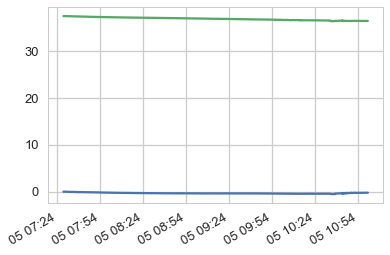

In [34]:
#########################
## Load processed data ##
#########################
dirPrint = dirPre + 'graphics'
dirProcessed = dirPre + 'proj/VertHarpExp2017Kloendeel/data/DTS_XT_VHSRE_processed'

os.chdir(dirProcessed)
ncFiles = ['VHRSE_chunk' + str(nFile) + '.nc' for nFile in np.arange(1, 10)]
ds = xr.open_mfdataset(ncFiles)
ds.attrs['locations'] = ds.attrs['locations'].split(';')

###################################################################################################################
# Extract out the XT times when it was managing the full experiment
expIndex = (ds.probe1Temperature < 100) & (ds.probe2Temperature < 100)\
            & (ds.probe2Temperature > 30) & (ds.probe1Temperature < 0)
ds = ds.isel(time=(expIndex == True))
ds = ds.sel(time=slice(pd.Timestamp(ds.time[0].values).to_pydatetime(), '2017-09-05 11:00'))

# Create a continuous time series
d1 = pd.Timestamp(ds.time[0].values).to_pydatetime()
d2 = pd.Timestamp(ds.time[-1].values).to_pydatetime()
fullTime = pd.date_range(start=d1, end=d2, freq='5s')
ds.reindex({'time': fullTime})

# Plot the resulting Dataset
print(ds)
fig, ax = plt.subplots(1, 1)
ax.plot(ds.time, ds.probe1Temperature)
ax.plot(ds.time, ds.probe2Temperature)
fig.autofmt_xdate()


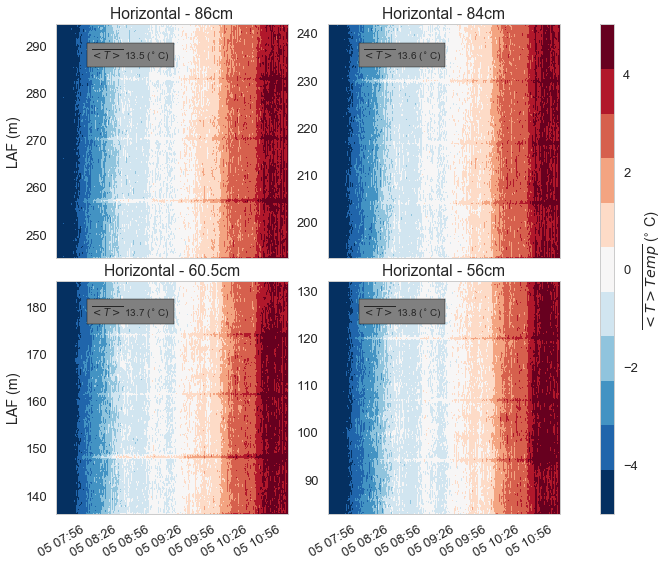

In [35]:
#########################
## Horizontal Segments ##
#########################
fig = plt.figure(figsize=(10, 10))
gs = matplotlib.gridspec.GridSpec(2, 3, width_ratios=np.append(np.ones(2) * 16, np.array(1)))
gs.update(wspace=0.25, hspace=0.1)
axNum = 0
cmap_delta = kgraph.cmap_discretize(cm.RdBu_r, 11)

for loc in ds.attrs['locations']:
    if 'Horizontal' in loc:
        if axNum == 2:
            axNum = axNum + 1
        ax = plt.subplot(gs[axNum])
        axNum = axNum + 1
        
        # Image of data for each section
        temp_ds = ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc)
        meanSectionTemp = temp_ds.mean(dim='time').mean(dim='location')
        temp_ds = temp_ds - meanSectionTemp
        H = np.ma.masked_array(temp_ds.values, np.isnan(temp_ds))
        t = temp_ds.time.values
        length = temp_ds.LAF.values
        X, Y = np.meshgrid(t, length)

        im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap_delta, vmin=-5, vmax=5)

        if not ax.is_last_row():
            ax.set_xticks([])
        if ax.is_first_col():
            ax.set_ylabel('LAF (m)')
        ax.set_title(loc)
        ax.text(0.15, 0.85, '$\overline{<T>}$ '
                + '{:.1f}'.format(np.asscalar(meanSectionTemp.values)) + ' ($^{\circ}$ C)',
                transform=ax.transAxes,
                bbox=dict(facecolor='grey'))
fig.autofmt_xdate()
caxi = plt.subplot(gs[:, -1])
cbar = plt.colorbar(im, cax=caxi, orientation='vertical', spacing='prop')
cbar.ax.set_ylabel('$\overline{<T> Temp}$ ($^{\circ}$ C)')

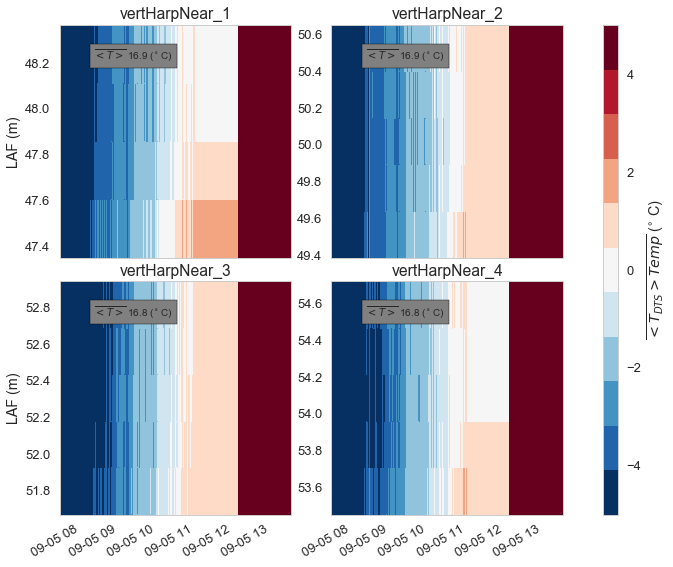

In [8]:
##############################
## Vertical (near) Segments ##
##############################
fig = plt.figure(figsize=(10, 10))
gs = matplotlib.gridspec.GridSpec(2, 3, width_ratios=np.append(np.ones(2) * 16, np.array(1)))
gs.update(wspace=0.25, hspace=0.1)
axNum = 0
cmap_delta = kgraph.cmap_discretize(cm.RdBu_r, 11)

for loc in ds.attrs['locations']:
    if 'vertHarpNear' in loc:
        if axNum == 2:
            axNum = axNum + 1
        ax = plt.subplot(gs[axNum])
        axNum = axNum + 1
        
        # Image of data for each section
        temp_ds = ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc)
        meanSectionTemp = temp_ds.mean(dim='time').mean(dim='location')
        temp_ds = temp_ds - meanSectionTemp
        H = np.ma.masked_array(temp_ds.values, np.isnan(temp_ds))
        t = temp_ds.time.values
        length = temp_ds.LAF.values
        X, Y = np.meshgrid(t, length)

        im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap_delta, vmin=-5, vmax=5)

        if not ax.is_last_row():
            ax.set_xticks([])
        if ax.is_first_col():
            ax.set_ylabel('LAF (m)')
        ax.set_title(loc)
        ax.text(0.15, 0.85, '$\overline{<T>}$ '
                + '{:.1f}'.format(np.asscalar(meanSectionTemp.values)) + ' ($^{\circ}$ C)',
                transform=ax.transAxes,
                bbox=dict(facecolor='grey'))

fig.autofmt_xdate()
caxi = plt.subplot(gs[:, -1])
cbar = plt.colorbar(im, cax=caxi, orientation='vertical', spacing='prop')
cbar.ax.set_ylabel('$\overline{<T_{DTS}> Temp}$ ($^{\circ}$ C)')

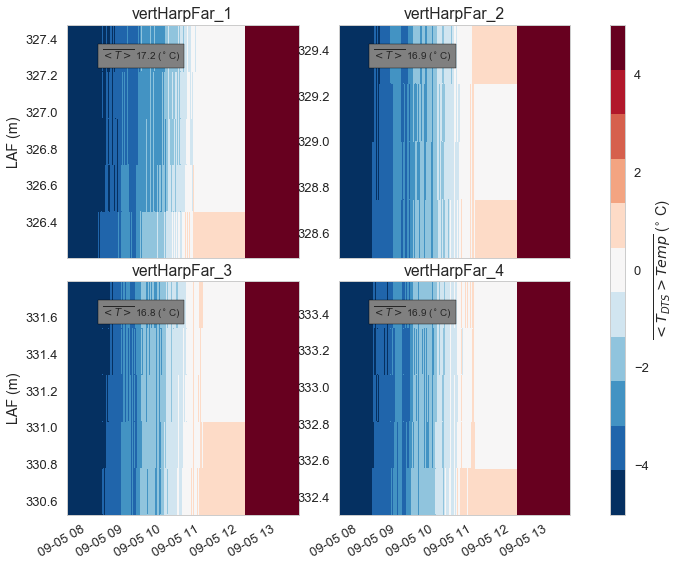

In [9]:
#############################
## Vertical (far) Segments ##
#############################
fig = plt.figure(figsize=(10, 10))
gs = matplotlib.gridspec.GridSpec(2, 3, width_ratios=np.append(np.ones(2) * 16, np.array(1)))
gs.update(wspace=0.25, hspace=0.1)
axNum = 0
cmap_delta = kgraph.cmap_discretize(cm.RdBu_r, 11)

for loc in ds.attrs['locations']:
    if 'vertHarpFar' in loc:
        if axNum == 2:
            axNum = axNum + 1
        ax = plt.subplot(gs[axNum])
        axNum = axNum + 1
        
        # Image of data for each section
        temp_ds = ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc)
        meanSectionTemp = temp_ds.mean(dim='time').mean(dim='location')
        temp_ds = temp_ds - meanSectionTemp
        H = np.ma.masked_array(temp_ds.values, np.isnan(temp_ds))
        t = temp_ds.time.values
        length = temp_ds.LAF.values
        X, Y = np.meshgrid(t, length)

        im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap_delta, vmin=-5, vmax=5)

        if not ax.is_last_row():
            ax.set_xticks([])
        if ax.is_first_col():
            ax.set_ylabel('LAF (m)')
        ax.set_title(loc)
        ax.text(0.15, 0.85, '$\overline{<T>}$ '
                + '{:.1f}'.format(np.asscalar(meanSectionTemp.values)) + ' ($^{\circ}$ C)',
                transform=ax.transAxes,
                bbox=dict(facecolor='grey'))

fig.autofmt_xdate()
caxi = plt.subplot(gs[:, -1])
cbar = plt.colorbar(im, cax=caxi, orientation='vertical', spacing='prop')
cbar.ax.set_ylabel('$\overline{<T_{DTS}> Temp}$ ($^{\circ}$ C)')

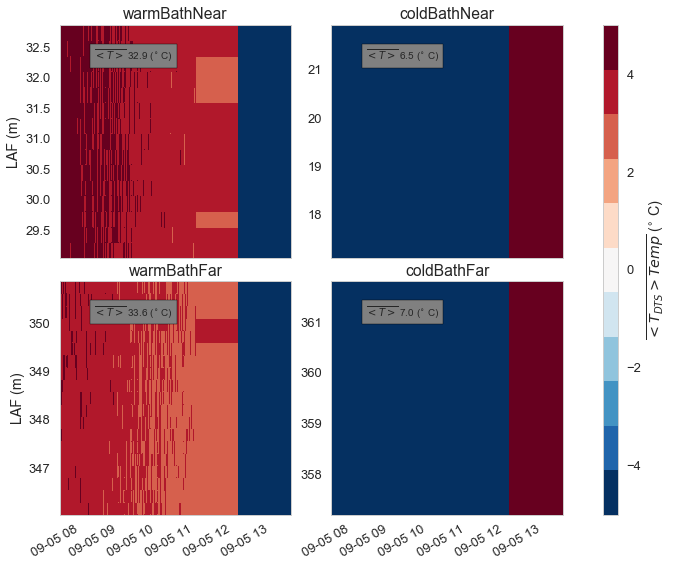

In [10]:
#####################
## Reference Baths ##
#####################
fig = plt.figure(figsize=(10, 10))
gs = matplotlib.gridspec.GridSpec(2, 3, width_ratios=np.append(np.ones(2) * 16, np.array(1)))
gs.update(wspace=0.25, hspace=0.1)
axNum = 0
cmap_delta = kgraph.cmap_discretize(cm.RdBu_r, 11)

for loc in ds.attrs['locations']:
    if 'Bath' in loc:
        if axNum == 2:
            axNum = axNum + 1
        ax = plt.subplot(gs[axNum])
        axNum = axNum + 1
        
        # Image of data for each section
        temp_ds = ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc)
        meanSectionTemp = temp_ds.mean(dim='time').mean(dim='location')
        temp_ds = temp_ds - meanSectionTemp
        H = np.ma.masked_array(temp_ds.values, np.isnan(temp_ds))
        t = temp_ds.time.values
        length = temp_ds.LAF.values
        X, Y = np.meshgrid(t, length)

        im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap_delta, vmin=-5, vmax=5)

        if not ax.is_last_row():
            ax.set_xticks([])
        if ax.is_first_col():
            ax.set_ylabel('LAF (m)')
        ax.set_title(loc)
        ax.text(0.15, 0.85, '$\overline{<T>}$ '
                + '{:.1f}'.format(np.asscalar(meanSectionTemp.values)) + ' ($^{\circ}$ C)',
                transform=ax.transAxes,
                bbox=dict(facecolor='grey'))

fig.autofmt_xdate()
caxi = plt.subplot(gs[:, -1])
cbar = plt.colorbar(im, cax=caxi, orientation='vertical', spacing='prop')
cbar.ax.set_ylabel('$\overline{<T_{DTS}> Temp}$ ($^{\circ}$ C)')

<xarray.DataArray 'time' ()>
array(1504608449000000000, dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-09-05T10:47:29


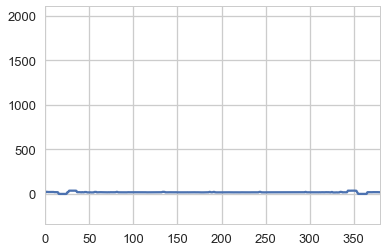

In [21]:
plt.plot(ds.LAF, ds.temp.sel(time=ds.time[2250]))
plt.gca().set_xlim(0, 380)
print(ds.time[2250])